# ADL HW2 - PCA and Autoencoders
In this assignment you will implement two dimensionality reduction schemes
we saw in class:
1. Principal Component Analysis (PCA)
2. Autoencoder

You will also implement an image denoising model to enhance the performance of a simple MLP classifier.

The data used in the following exercises is a subset of the MNIST dataset.
Randomly sample 10,000 images from MNIST train set (you may set a random.seed).

# Submission Date: 05.01.2025
Submit the already-run notebook.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

# EX1. PCA dimensionality reduction (10pts)

1. Implement the PCA procedure in the function ```perform_PCA()```.

Useful functions:
```
sklearn.preprocessing.StandardScaler
scipy.linalg.eigh
numpy.matmul
```
The input should be in vector form (i.e., flatten the input images beforehand).

2. Project the data to 2D, i.e, $\mathbb{R}^{784}↦ \mathbb{R}^2$.
3. Scatter plot the data using the 2D projection and class labels. You'll need to implement ```plot_projected_data()```


In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import seaborn as sns

def perform_PCA(X, n_components):
    """
    Implement the PCA algorithm.
    Input: X [numpy array] - shape: (N, 784)
           n_components [int] - number of components to keep
    Output: Projected data using n_components
    """
    # Step 1: Standardize the data
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # Step 2: Compute the covariance matrix
    # contains the covariances between each pair of variables (columns) in X
    covariance_matrix = np.cov(X_standardized, rowvar=False)

    # Step 3: Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(covariance_matrix)

    # Step 4: Select the top n_components
    # We want the n variables with the largest variance
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort in descending order
    top_indices = sorted_indices[:n_components]
    top_eigenvectors = eigenvectors[:, top_indices]

    # Step 5: Project the data onto the top eigenvectors
    # We project X onto the space of n chosen variables
    X_projected = np.matmul(X_standardized, top_eigenvectors)

    return X_projected

def plot_projected_data(X, y):
    """
    Scatter plot the projected data with class labels.
    Input: X [numpy array] - shape: (N, 2)
           y [numpy array] - shape: (N,) class labels
    """

    classes = np.unique(y)
    clrs = sns.color_palette('gist_rainbow', n_colors=10)  # a list of RGB tuples
    for k in classes:

      # Take samples within class
      Xk = X[y==k]
      yk = y[y==k]
      color = clrs[k]
      plt.scatter(Xk[:,0], Xk[:,1], color=color, label=k)
    plt.grid()
    plt.legend()
    plt.show()

In [3]:
# For EX5, Please use the (0.5, 0.5) normalization value, as
# they were used for training the MLP
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Sample 10K images
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

trainloader = DataLoader(train_subset , batch_size=256, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.01MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


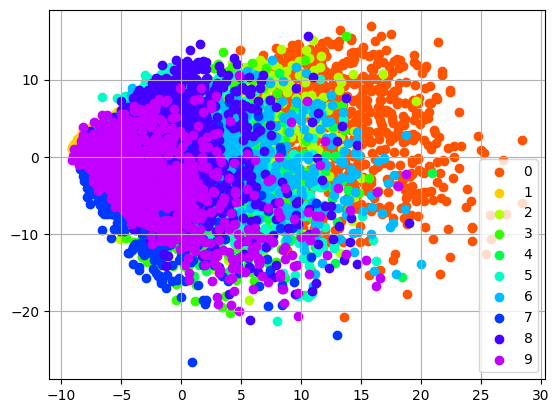

In [4]:
### Your code goes here ###

X_train, y_train = [], []
for images, labels in trainloader:
    X_train.append(images.view(images.size(0), -1).numpy())
    y_train.append(labels.numpy())

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

X_projected = perform_PCA(X_train, n_components=2)
plot_projected_data(X_projected, y_train)

# EX2 Autoencoder (AE) (15pts)
1. Implement a fully-connected Autoencoder. The encoder and decoder should have 2 layers each. Use ReLU activation function.
2. The so-called 'code' should be two-dimensional. In other words, the output of the encoder should be 2.
3. Plot the training loss.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [5]:
class nonlinear_autoencoder(nn.Module):
    def __init__(self):
      super(nonlinear_autoencoder, self).__init__()

      self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 2))

      self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28))

    def forward(self,x):
        x = x.view(-1, 784)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


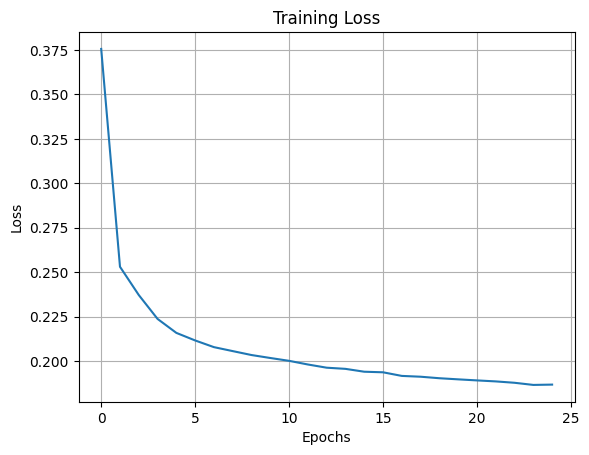

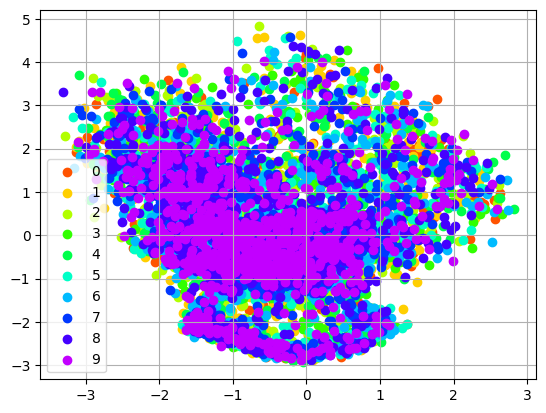

In [6]:
### Your code goes here ###

model = nonlinear_autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, epochs=25):

  model.train()
  loss_list = []

  for epoch in range(epochs):

    running_loss = 0.0

    for images, _ in train_loader:

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_list.append(running_loss/len(train_loader))
    # print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

  plot_loss(loss_list)

def plot_loss(loss_list):

  plt.plot(loss_list)
  plt.grid()
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.title("Training Loss")
  plt.show()

train(model, trainloader, criterion, optimizer, epochs=25)

model.eval()
encoded_images = []

with torch.no_grad():
    for images, _ in trainloader:
        images = images.view(images.size(0), -1)  # Flatten each image
        encoded = model.encoder(images).numpy()
        encoded_images.append(encoded)

# Convert list to numpy array
nonlinear_encoded_images = np.concatenate(encoded_images, axis=0)

# Visualize the 2D projection of the data
labels = np.array([label for _, label in train_subset])
plot_projected_data(nonlinear_encoded_images, labels)

# EX3 Linear Autoencoder (15pts)
1. Follow the steps of EX2, but remove the nonlinear activation functions.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [8]:
class linear_autoencoder(nn.Module):
    def __init__(self):
      super(linear_autoencoder, self).__init__()

      self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.Linear(256, 2))

      self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.Linear(256, 28*28))

    def forward(self,x):
        x = x.view(-1, 784)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

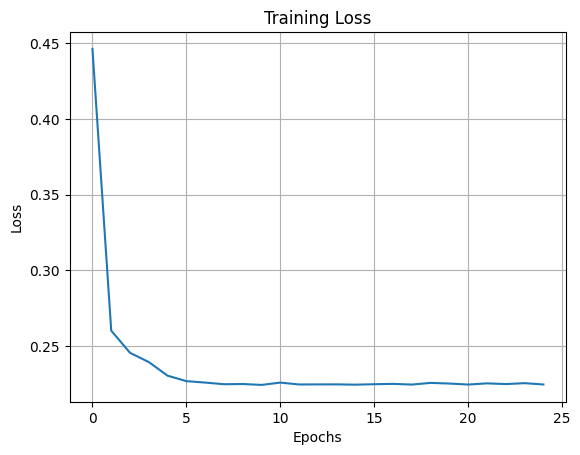

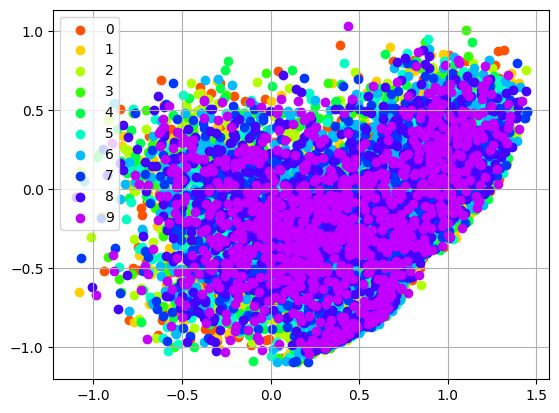

In [9]:
### Your code goes here ###

model = linear_autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, trainloader, criterion, optimizer, epochs=25)

model.eval()
encoded_images = []

with torch.no_grad():
    for images, _ in trainloader:
        images = images.view(images.size(0), -1)  # Flatten each image
        encoded = model.encoder(images).numpy()
        encoded_images.append(encoded)

# Convert list to numpy array
linear_encoded_images = np.concatenate(encoded_images, axis=0)

# Visualize the 2D projection of the data
labels = np.array([label for _, label in train_subset])
plot_projected_data(linear_encoded_images, labels)

# EX 4 - Discussion (10pts)
1. Write a new plotting function and plot the results side-by-side using subplots.
2. Given the three figures and what we've learned about PCA and AE, answer what are the difference/similarites between the models? How is that indicated in the results?


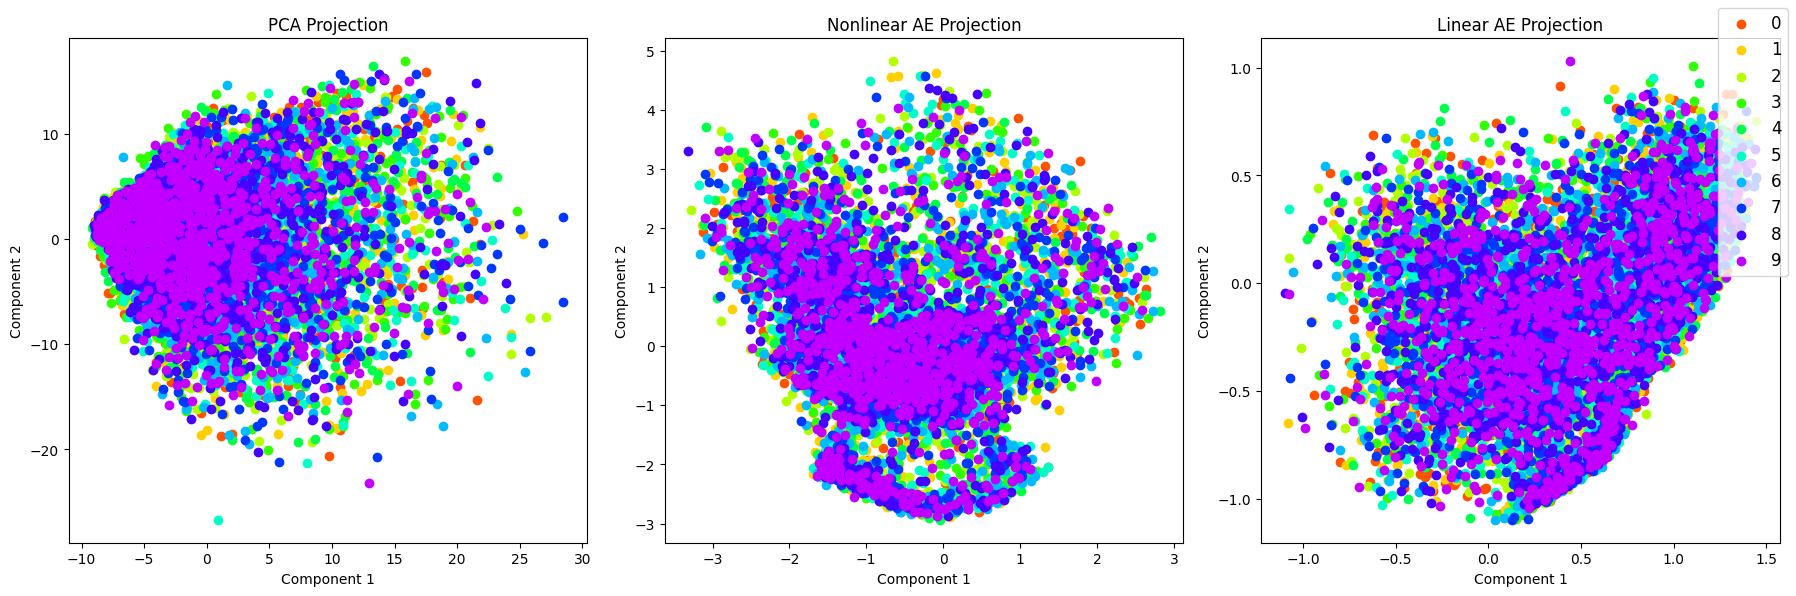

In [10]:
def plot_comparisons(pca_data, nonlinear_ae_data, linear_ae_data, labels):

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    titles = ['PCA Projection', 'Nonlinear AE Projection', 'Linear AE Projection']
    data_list = [pca_data, nonlinear_ae_data, linear_ae_data]

    classes = np.unique(labels)
    clrs = sns.color_palette('gist_rainbow', n_colors=10)  # a list of RGB tuples

    for i, ax in enumerate(axes):

        for k in classes:

            Xk = data_list[i][labels==k]
            yk = labels[labels==k]
            color = clrs[k]
            ax.scatter(Xk[:,0], Xk[:,1], color=color, label=k)

            ax.set_title(titles[i])
            ax.set_xlabel('Component 1')
            ax.set_ylabel('Component 2')
            ax.grid()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_comparisons(X_projected, nonlinear_encoded_images, linear_encoded_images, labels)

In [ ]:
"""
PCA and Linear AE show a relatively symmetric, continuous distribution of points.
Nonlinear AE shows a more irregular, clustered pattern, reflecting its capacity to capture non-linear structures.

PCA and Linear AE focus on maximizing variance or reconstructing linear relationships.
Nonlinear AE is tailored to approximate the manifold structure of data,
making it more powerful for tasks like clustering or visualization of non-linear data.

Notice that the scales differ between the graphs, with the PCA graph having the largest values,
while the Linear AE graph exhibits the smallest values.

  The values (scalars) on the PCA graph are directly proportional
  to the variance of the original data along the principal components.
  If the original data has high variability,
  the PCA graph will reflect this with larger scales.

  the output of a linear model reflects weights or coefficients
  that are tied to specific features, often resulting in smaller values.
"""

# EX 5 - Denoising AE and Classification (50pts.)
In this section you will implement and train a denosing AE to clean corrupted MNIST images.
You are given a trained MLP model (from DL PS1) with ~94% test set accuracy on the cleaned images. Again, work with only 10k images (a subset of the train set).
Your tasks are as follows:
0. Load the mlp.pth file to your project (not google drive dir) and initiate the MLP model with the trained weights.
1. Compute the test set accuracy for the clean and corrupted datasets.
2. Implemented and train autoencoder to remove the noise.
3. Visualize the results for 10 images, one for each digit (original image, corrupted image, clean image).
4. Compute the test set accuracy on the cleaned/denoised corrupted test set. Due to the randomness of the gaussian noise, run the procedure 5 times and take the average accuracy.

You **may not re-train** the classification network or train a new model for classification task.

There is **no need** to submit the trained model weights.

### Grading for this section:
```python
50pts = max(cleaned image accuracy + 10, 100)*0.5 #(i.e, accuracy >= 90% will give you a full grade).
```

You will also be evaluated on the quality of your code and apporach.

## Load trained model

In [13]:
# MLP classifier from DL PS1 - DO NOT CHANGE
mlp_clf = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_clf.load_state_dict(torch.load('mlp.pth', map_location=torch.device(device)))

<ipython-input-13-310ad3651e44>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_clf.load_state_dict(torch.load('mlp.pth', map_location=torch.device(device)))


<All keys matched successfully>

## Data and functions

In [16]:
# Noise function - DO NOT CHANGE
def add_gaussian_noise(images, mean=0.0, std=2):
    noise = torch.randn(images.size()) * std + mean
    noisy_images = images + noise
    return noisy_images


# Accuracy - DO NOT CHANGE
def compute_accuracy(model, testloader, denoise_model=None, add_noise=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # False for clean images, True for corrupted/noisy
            if add_noise:
              images = add_gaussian_noise(images)
            # Denoise the image before the classifier
            if denoise_model is not None:
              images = denoise_model(images)
            # reshape to vector form for the MLP
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [17]:
# Compute and print test accuracy for clean and corrupted images

clean_accuracy = compute_accuracy(mlp_clf, testloader, add_noise=False)
print(f"Accuracy on clean test set: {clean_accuracy:.2f}%")

corrupted_accuracy = compute_accuracy(mlp_clf, testloader, add_noise=True)
print(f"Accuracy on corrupted test set: {corrupted_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy on clean test set: 93.98%
Accuracy on corrupted test set: 60.25%


In [94]:
class CNN_autoencoder(nn.Module):

    def __init__(self):
        super(CNN_autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1))

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class autoencoder(nn.Module):
  def __init__(self):

    super(autoencoder, self).__init__()

    self.code_size = 64

    self.encoder = nn.Sequential(
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, self.code_size))

    self.decoder = nn.Sequential(
      nn.Linear(self.code_size, 128),
      nn.ReLU(),
      nn.Linear(128, 256),
      nn.ReLU(),
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, 28*28))

  def forward(self, x):
    x = x.view(-1, 28*28)
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    decoded = decoded.view(-1, 1, 28, 28)
    return decoded


def train(model, train_loader, criterion, optimizer, epochs=25):

  model.train()

  for epoch in range(epochs):

    loss_epoch = 0

    for images, labels in train_loader:

      # Batch loss for updating the model
      optimizer.zero_grad()

      # Add Gaussian noise
      noisy_images = add_gaussian_noise(images)

      # Forward pass
      reconstructed = model(noisy_images)

      # Reconstruction loss
      loss = criterion(reconstructed, images)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      loss_epoch += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Reconstruction loss: {loss_epoch / len(trainloader):.4f}")

  return model

In [96]:
model_AE =  autoencoder()
criterion = nn.MSELoss()
optimizer_AE = optim.Adam(model_AE.parameters(), lr=0.001)

model_AE = train(model_AE, trainloader, criterion, optimizer_AE, epochs=50)

Epoch [1/50], Reconstruction loss: 0.3622
Epoch [2/50], Reconstruction loss: 0.2687
Epoch [3/50], Reconstruction loss: 0.2678
Epoch [4/50], Reconstruction loss: 0.2633
Epoch [5/50], Reconstruction loss: 0.2471
Epoch [6/50], Reconstruction loss: 0.2361
Epoch [7/50], Reconstruction loss: 0.2204
Epoch [8/50], Reconstruction loss: 0.2079
Epoch [9/50], Reconstruction loss: 0.1960
Epoch [10/50], Reconstruction loss: 0.1865
Epoch [11/50], Reconstruction loss: 0.1795
Epoch [12/50], Reconstruction loss: 0.1713
Epoch [13/50], Reconstruction loss: 0.1653
Epoch [14/50], Reconstruction loss: 0.1606
Epoch [15/50], Reconstruction loss: 0.1569
Epoch [16/50], Reconstruction loss: 0.1541
Epoch [17/50], Reconstruction loss: 0.1525
Epoch [18/50], Reconstruction loss: 0.1499
Epoch [19/50], Reconstruction loss: 0.1477
Epoch [20/50], Reconstruction loss: 0.1453
Epoch [21/50], Reconstruction loss: 0.1438
Epoch [22/50], Reconstruction loss: 0.1422
Epoch [23/50], Reconstruction loss: 0.1414
Epoch [24/50], Recon

In [103]:
model_CNN =  CNN_autoencoder()
criterion = nn.MSELoss()
optimizer_CNN = optim.Adam(model_CNN.parameters(), lr=0.001)

model_CNN = train(model_CNN, trainloader, criterion, optimizer_CNN, epochs=25)

Epoch [1/25], Reconstruction loss: 0.3560
Epoch [2/25], Reconstruction loss: 0.2105
Epoch [3/25], Reconstruction loss: 0.1862
Epoch [4/25], Reconstruction loss: 0.1736
Epoch [5/25], Reconstruction loss: 0.1667
Epoch [6/25], Reconstruction loss: 0.1618
Epoch [7/25], Reconstruction loss: 0.1574
Epoch [8/25], Reconstruction loss: 0.1545
Epoch [9/25], Reconstruction loss: 0.1529
Epoch [10/25], Reconstruction loss: 0.1510
Epoch [11/25], Reconstruction loss: 0.1494
Epoch [12/25], Reconstruction loss: 0.1478
Epoch [13/25], Reconstruction loss: 0.1466
Epoch [14/25], Reconstruction loss: 0.1456
Epoch [15/25], Reconstruction loss: 0.1456
Epoch [16/25], Reconstruction loss: 0.1445
Epoch [17/25], Reconstruction loss: 0.1432
Epoch [18/25], Reconstruction loss: 0.1446
Epoch [19/25], Reconstruction loss: 0.1432
Epoch [20/25], Reconstruction loss: 0.1420
Epoch [21/25], Reconstruction loss: 0.1427
Epoch [22/25], Reconstruction loss: 0.1415
Epoch [23/25], Reconstruction loss: 0.1414
Epoch [24/25], Recon

In [98]:
def get_images(model, data_loader):

  digit_shown = [False] * 10

  original_images = []
  corrupted_images = []
  reconstructed_images = []

  for images, labels in data_loader:

    images = images.view(images.size(0), 1, 28, 28)

    original_batch = images
    corrupted_batch = add_gaussian_noise(images)
    reconstructed_batch = model(corrupted_batch)

    for i in range(len(images)):

      digit = labels[i].item()

      if not digit_shown[digit]:

        original_images.append(original_batch[i].view(1, 28, 28))
        corrupted_images.append(corrupted_batch[i].view(1, 28, 28))
        reconstructed_images.append(reconstructed_batch[i].view(1, 28, 28))
        digit_shown[digit] = True

      if all(digit_shown):
          break

    if all(digit_shown):
      break

  return original_images, corrupted_images, reconstructed_images

def plot_images(original_images, corrupted_images, reconstructed_images):

  figure1 = plt.figure(figsize=(10,3))
  num_of_images = 10
  for index in range(1, num_of_images + 1):
      plt.subplot(3, 10, index)
      plt.axis('off')
      plt.imshow(original_images[index-1].squeeze(), cmap='gray')
  plt.tight_layout()
  plt.suptitle("original images", y=1.05, fontsize=20)

  figure2 = plt.figure(figsize=(10,3))
  num_of_images = 10
  for index in range(1, num_of_images + 1):
      plt.subplot(3, 10, index)
      plt.axis('off')
      plt.imshow(corrupted_images[index-1].squeeze(), cmap='gray')
  plt.suptitle("corrupted images", y=1.05, fontsize=20)
  plt.tight_layout()
  plt.show()

  figure3 = plt.figure(figsize=(10,3))
  num_of_images = 10
  for index in range(1, num_of_images + 1):
      plt.subplot(3, 10, index)
      plt.axis('off')
      plt.imshow(reconstructed_images[index-1].detach().cpu().numpy().squeeze(), cmap='gray')
  plt.tight_layout()
  plt.suptitle("reconstructed images", y=1.05, fontsize=20)

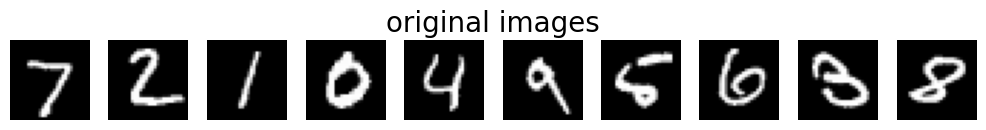

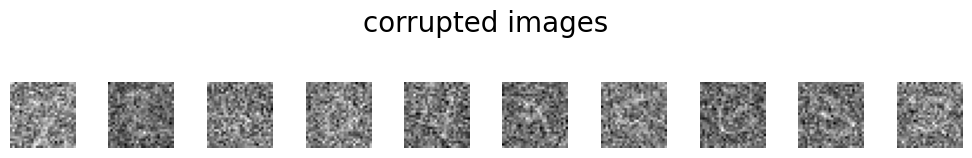

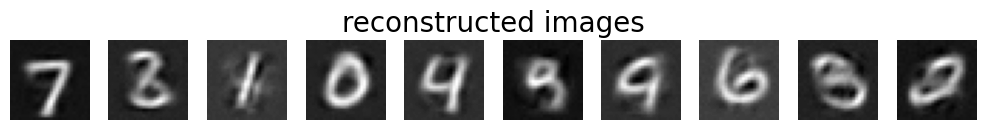

In [105]:
original_images, corrupted_images, reconstructed_images = get_images(model_AE, testloader)
plot_images(original_images, corrupted_images, reconstructed_images)

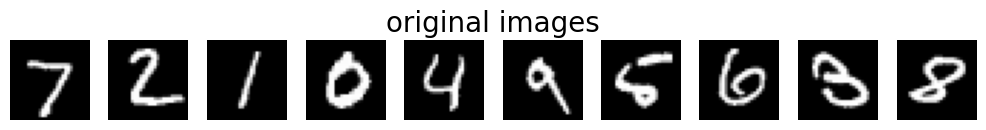

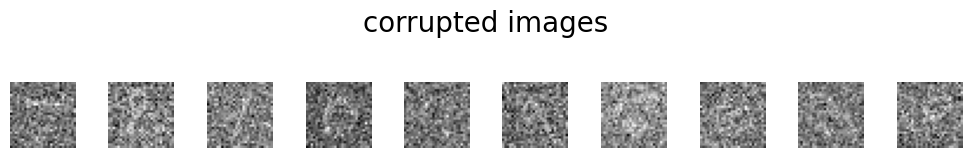

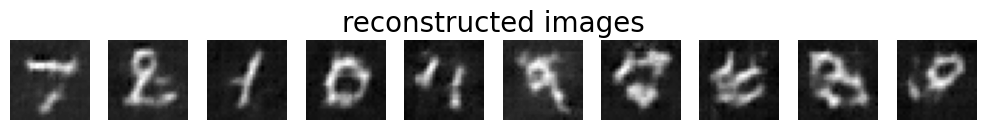

In [106]:
original_images, corrupted_images, reconstructed_images = get_images(model_CNN, testloader)
plot_images(original_images, corrupted_images, reconstructed_images)

In [107]:
denoised_accuracies = []
num_trials = 5

for trial in range(num_trials):
  corrupted_accuracy = compute_accuracy(mlp_clf, testloader, model_AE, add_noise=True)
  denoised_accuracies.append(corrupted_accuracy)
  print(f"Accuracy on corrupted test set (trail {trial + 1}): {corrupted_accuracy:.2f}%")

average_accuracy = sum(denoised_accuracies) / num_trials
print(f"Average accuracy on denoised data: {average_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy on corrupted test set (trail 1): 80.73%
Accuracy on corrupted test set (trail 2): 80.84%
Accuracy on corrupted test set (trail 3): 80.77%
Accuracy on corrupted test set (trail 4): 80.45%
Accuracy on corrupted test set (trail 5): 81.15%
Average accuracy on denoised data: 80.79%


In [108]:
denoised_accuracies = []
num_trials = 5

for trial in range(num_trials):
  corrupted_accuracy = compute_accuracy(mlp_clf, testloader, model_CNN, add_noise=True)
  denoised_accuracies.append(corrupted_accuracy)
  print(f"Accuracy on corrupted test set (trail {trial + 1}): {corrupted_accuracy:.2f}%")

average_accuracy = sum(denoised_accuracies) / num_trials
print(f"Average accuracy on denoised data: {average_accuracy:.2f}%")

Accuracy on corrupted test set (trail 1): 73.35%
Accuracy on corrupted test set (trail 2): 73.45%
Accuracy on corrupted test set (trail 3): 73.12%
Accuracy on corrupted test set (trail 4): 73.22%
Accuracy on corrupted test set (trail 5): 73.24%
Average accuracy on denoised data: 73.28%


In [ ]:
"""
We performed this experiment with two different models.
The first model is a CNN, for which we likely did not tune the parameters optimally,
resulting in accuracy percentages around 70%.
In contrast, for the FC model, we achieved better accuracy, reaching 80%.
"""